### Hansen(1985): Discrete Dynamic Programming

#### Translated from Eva Carceles-Poveda's MATLAB codes

In [1]:
# Importing packages
import numpy as np
import matplotlib.pyplot as plt
# The magic command below causes the resulting plots to be stored in the notebook document
# Only works in IPython Notebooks and not in regular Python files
%matplotlib inline

# This is used to calculate the excution time of several loops
import time

# This is used for the root_scalar function
from scipy.optimize import root_scalar

# needed for compact printing of numpy arrays
# use precision to set the number of decimal digits to display
# use suppress=True to show values in full decimals instead of using scientific notation
np.set_printoptions(suppress=True,precision=4,linewidth=np.inf)

#### The function markov_approx is copied below.

In [2]:
# markovapprox: approximates a continuous AR(1) process with a Markov chain
# Eva Carceles-Poveda's version. You can use this function, Floden's tauchen function, or Sargent's tauchen function.

from scipy.stats import norm
def markov_approx(rho, sigma, m, N):
    """ Syntax: [Tran,s,p,arho,asigma]=markovapprox(rho,sigma,m,N)
    
    This function approximates a first-order autoregressive process 
    with persistence rho and innovation standard deviation sigma with 
    an N state Markov chain; m determines the width of the discretized 
    state space, Tauchen uses m=3, with ymax=m*vary,ymin=-m*vary, where 
    ymax and ymin are the two boundary points, Tran is the transition 
    matrix of the Markov chain, s is the discretized state space, p is 
    the chain stationary distribution, arho is the theoretical first 
    order autoregression coefficient for the Markov chain, asigma is 
    the theoretical standard deviation for the Markov chain.
    
    Translated from Eva Carceles-Poveda 2003 MATLAB code
    """
    
    # Discretize the state space
    stvy = np.sqrt(sigma**2/(1-rho**2))   # standard deviation of y(t)
    ymax = m*stvy                         # upper boundary of state space
    ymin = -ymax                          # lower boundary of state space
    w = (ymax-ymin)/(N-1)                 # distance between points
    s = w * np.arange(ymin/w, ymax/w+1)   # the discretized state space        
    
    
    # Calculate the transition matrix
    Tran = np.zeros((N,N))
    for j in np.arange(0,N):
        for k in np.arange(1,N-1):
            Tran[j,k] = norm.cdf(s[k]-rho*s[j]+w/2,0,sigma) - norm.cdf(s[k]-rho*s[j]-w/2,0,sigma);
            
        Tran[j,0] = norm.cdf(s[0]-rho*s[j]+w/2,0,sigma);
        Tran[j,N-1] = 1 - norm.cdf(s[N-1]-rho*s[j]-w/2,0,sigma);
        
    # Check that Tran is well specified
    if not np.all(np.isclose(np.sum(Tran.T, axis=0), np.squeeze(np.ones((1,N))))):
        # find rows not adding up to one
        str = (np.absolute(np.sum(Tran.T, axis=0))-np.squeeze(np.ones((1,N)))<1e-14).nonzero()          
        print('error in transition matrix')
        print('rows', str[0],' do not sum to one')
    
    
    # Calculate the invariant distribution of Markov chain
    Trans = Tran.T
    p = (1/N)*np.ones((N,1)) # initial distribution of states
    test = 1;
    while test > 1e-8:
        p1 = np.matmul(Trans,p)
        test=np.max(np.abs(p1-p))
        p = p1
    
    
    meanm = np.matmul(s,p)            # mean of invariant distribution of chain
    varm = np.matmul((s-meanm)**2,p)  #variance of invariant distribution of chain  
    midaut1 = np.matmul((s-meanm)[:, np.newaxis],(s-meanm)[np.newaxis, :]) # cross product of deviation from mean of yt and yt-1                    
    probmat = np.matmul(p,np.ones((1,N)))     # each column is invariant distribution   
    midaut2 = Tran*probmat*midaut1 # product of the first two terms is joint distribution of (Yt-1,Yt)                                    
    autcov1 = np.sum(midaut2)    #  first-order auto-covariance
    
    
    arho = autcov1/varm           # theoretical first order autoregression coefficient
    asigma = np.sqrt(varm)           # theoretical standard deviation
    
    return Tran, s, p, arho, asigma

#### The functions lgwt and acm are copied below.

In [3]:
def lgwt(N,a,b):
    """ Syntax: [x,w]=lgwt(N,a,b)
    
    This script is for computing definite integrals using Legendre-Gauss 
    Quadrature. Computes the Legendre-Gauss nodes and weights on an interval
    [a,b] with truncation order N.
    
    Suppose you have a continuous function f(x) which is defined on [a,b]
    which you can evaluate at any x in [a,b]. Simply evaluate it at all of
    the values contained in the x vector to obtain a vector f. Then compute
    the definite integral using sum(f.*w);
    
    Translated from Greg von Winckel's Matlab Script written on 02/25/2004
    """

    N = N-1
    N1 = N+1; N2 = N+2;

    xu = np.linspace(-1,1,N1)

    # Initial guess
    y=np.cos((2*np.arange(0,N+1)+1)*np.pi/(2*N+2))+(0.27/N1)*np.sin(np.pi*xu*N/N2)

    # Compute the zeros of the N+1 Legendre Polynomial
    # using the recursion relation and the Newton-Raphson method

    y0=2

    # Iterate until new points are uniformly within epsilon of old points
    while np.abs(y-y0).max() > np.finfo(float).eps:
        
        # Legendre-Gauss Vandermonde Matrix
        L=np.zeros((N1,N2))

        # Derivative of LGVM
        Lp=np.zeros((N1,N2))
        
        L[:,0]=1
        Lp[:,0]=0

        L[:,1]=y
        Lp[:,1]=1
        
         
        for k in np.arange(1,N1):
            L[:,k+1]=( (2*(k+1)-1)*y*L[:,k]-((k+1)-1)*L[:,k-1] )/(k+1)

            
        Lp=(N2)*(L[:,N1-1]-y*L[:,N2-1] )/(1-y**2)

        y0=y.copy()
        y=y0-L[:,N2-1]/Lp


    # Linear map from[-1,1] to [a,b]
    x = ((a*(1-y)+b*(1+y))/2).T

    # Compute the weights
    w = ((b-a)/((1-y**2)*Lp**2)*(N2/N1)**2).T
       
    return x, w

In [4]:
# scipy.stats.norm: a normal continuous random variable.
from scipy.stats import norm

# needed for Gauss-Lobatto only
from scipy.integrate import quad

# Adda-Cooper's method of approximating an AR(1) process with normally distributed innovation.
def acm(mu,rho,sigma,n,me=1):
    """ Syntax: [ss,tm,sd,sm,ssd,sac] = acm(mu,rho,sigma,n,me) 

    ss is state space, tm is transition matrix, sd is stationary distribution,
    sm is stationary mean, ssd is stationary standard deviation and sac is 
    stationary autocorrelation. mu is the mean of the AR process, rho is 
    the autocorrelation and sigma is the standard deviation of the innovation.
    n is the number of states and me stands for the method used in numerical integration.
    """
    
    tm = np.zeros((n,n))
    sg = sigma / (np.sqrt(1 - rho**2))     # sg is the variance of AR process
    
    # n + 1 interval nodes for defining the states, trucated at two ends.
    node = sg * norm.ppf(np.arange(0,n+1) / n + np.concatenate((np.array([np.spacing(1)]), np.zeros((1,n - 1))[0],\
                                                                    (np.array([-np.spacing(1)]))))) + mu
    

    # lengths of n intervals.
    itv = node[1:n + 1] - node[0:n]
    

    ss = n * sg * (norm.pdf((node[0:n] - mu) / sg) - norm.pdf((node[1:n+1] - mu) / sg)) + mu
    
    # itvu is the upper bound of an interval, itvl likewise.
    f = lambda u,itvu,itvl: np.exp(-(u - mu)**2 / 2 / sg**2)*\
    (norm.cdf((itvu - mu*(1 - rho) - rho*u)/sigma) -\
     norm.cdf((itvl - mu*(1 - rho) - rho*u)/sigma)) / np.sqrt(2 * np.pi) / sg
    
    
    match me:
        case 1:
            # use Gauss-Legendre method

            # Generate 10 nodes and corresponding weights using Winckel's function lgwt.
            m = 10
            x,w = lgwt(m,-1,1)    

            start = time.perf_counter()
            for i in np.arange(0,n):
                f_i = lambda u: f(u,node[i + 1],node[i])
                tm[i,:] = 0.5 * itv * (np.matmul(w,f_i(np.matmul((x + 1)[:,np.newaxis], itv[np.newaxis,:]) / 2 \
                                                    + np.ones((m,1)) * node[0:n])))

                tm[i,:] = tm[i,:]/np.sum(tm[i,:])
                

            stop = time.perf_counter()
            print("Time of the Gauss-Legendre method is:", round(stop - start,4))

        
        case 2:
            # use recursive adaptive Gauss-Lobatto quadrature
            start = time.perf_counter()
            for i in np.arange(0,n):
                f_i = lambda u: f(u,node[i + 1],node[i])
                for j in np.arange(0,n):
                    tm[i,j] = quad(f_i,node[j],node[j + 1])[0]

                tm[i,:] = tm[i,:]/np.sum(tm[i,:])

            stop = time.perf_counter()
            print("Time of Gauss-Lobatto method is:", round(stop - start,4))

    sd = np.dot((np.concatenate((np.zeros((1,7 - 1))[0],(np.array([1]))))),\
    np.linalg.inv((np.append(tm[:,0:n - 1] - np.eye(n,n - 1),np.ones((n,1)),1))))
    sd = sd / sum(sd)
    sm = np.dot(sd, ss)
    ssd = np.sqrt(np.dot((ss - sm)**2, sd.T))

    sac = (np.matmul((ss[:,np.newaxis] - sm),ss[np.newaxis,:] - sm) *\
           np.matmul(np.diag(sd),tm)).sum(axis=1).sum(axis=0) / ssd**2
        
        
    return ss,tm,sd,sm,ssd,sac

#### The Hodrick-Prescott filter function is copied below

In [5]:
def hp1(y,w):

    """ Syntax: yhp, ytr = hp1(y, w)
    
    This function computes the filtered series of y, using
    a smoothing parameter w. 
    
    The code is from I. Izvorski.
    """

    t, s = y.shape
    
    if t < s:
        y = y.T

    a = 6*w + 1
    b = -4*w
    c = w
    d = np.array([[c,b,a]])
    d = np.ones((t,1))*d
    m = np.diag(d[:,2])+np.diag(d[0:-1,1],1)+np.diag(d[0:-1,1],-1)
    m = m+np.diag(d[0:-2,0],2)+np.diag(d[0:-2,0],-2)

    m[0,0] = 1+w;       m[0,1] = -2*w;
    m[1,0] = -2*w;      m[1,1] = 5*w+1;
    m[-2,-2] = 5*w+1;   m[-2,-1] = -2*w;
    m[-1,-2] = -2*w;    m[-1,-1] = 1+w;
    
    ytr = np.matmul(np.linalg.inv(m),y)
    yhp = y-ytr

    return yhp, ytr

In [6]:
def lfoc(X,zt,ki,kj,alf,a,delta):
    # This function solves optial labor policy from intratemporal condition 
    # and RC in the dynamic programming system.
    
    c = zt*ki**alf*X**(1-alf)+(1-delta)*ki-kj
    F = c/(1-X)-(1-alf)/a*zt*ki**alf*X**(-alf)

    return F


In [7]:
# Model Parameters
alf = 0.36
beta = 0.99
a = 2
delta = 0.025
rho = 0.95
sigmae = 0.00712

In [8]:
# Algorithm Parameters
siyes = 1       # simulte model if equals to 1
loadin = 0      # load policy functions if equals 1
loadsimuin = 0  # load simulation results if equals to 1
stationary = 1  # finds stationary distribution for capital
tolv = 1e-12    # tolerance level

In [9]:
# Discretize continuous shocks into Markov process
N = 7          # 7 state Markov chain
m = 3
zbar = 1       # unconditional mean of z
#z,Tran = acm(0,rho,sigmae,N,1)[0:2]  # Adda-Cooper Shocks
Tran, z, p, arho, asigma = markov_approx(rho,sigmae,m,N) # Shocks by Tauchen method 
z=np.exp(z)

lt = z.size # lt is the same size as N.
Pi = np.linalg.matrix_power(Tran, 10000)
Ez = 1


In [10]:
# Define Steady state variables
xx = (1-beta*(1-delta))/(beta*alf*Ez)
yy = ((1/beta+delta-1)/alf*(1+(1-alf)/a)-delta)*a/((1-alf)*Ez)
l_ss = xx/yy  # for this set of parameters, the steady state labor approxiamately equals to 1/3
k_ss = xx**(1/(alf-1))*l_ss
y_ss = Ez*k_ss**alf*l_ss**(1-alf)
i_ss = delta*k_ss
c_ss = y_ss-i_ss

In [11]:
# Define capital grid
kmin = 0.894*k_ss
kmax = 1.115*k_ss

lk = 200
gdk = (kmax-kmin)/(lk-1)
k = np.linspace(kmin,kmax,lk)
gk = lk*lk

In [12]:
# Compute objective function
c = np.zeros((gk,lt))
l = np.zeros((gk,lt))
lmin = 1e-5
lmax = 1-lmin


for t in np.arange(0,lt):
    for i in np.arange(0,lk):  # today's capital
        for j in np.arange(0,lk):  # tomorrow's capital
            # this if-elseif loop helps to set up reasonable range of l so
            # that we will not get NAN
            if k[j]-(1-delta)*k[i]> 0 and ((k[j]-(1-delta)*k[i])/(z[t]*k[i]**alf))**(1/(1-alf)) < lmax:
                L = root_scalar(lfoc, args=(z[t],k[i],k[j],alf,a,delta), \
                          bracket=[((k[j]-(1-delta)*k[i])/(z[t]*k[i]**alf))**(1/(1-alf)),lmax]).root
            elif k[j]-(1-delta)*k[i]<0:
                L = root_scalar(lfoc, args=(z[t],k[i],k[j],alf,a,delta), bracket=[lmin,lmax]).root

            if L < 0:
                L=lmin
            elif L > 1:
                L=lmax

            l[i*lk+j,t] = L
            c[i*lk+j,t] = z[t]*(k[i]**alf)*L**(1-alf)+(1-delta)*k[i]-k[j]
            if c[i*lk+j,t] < 0:
                c[i*lk+j,t] = 1e-12

U = np.log(c)+a*np.log(1-l)

In [13]:
# Initialization of the value function
V0 = np.ones((lk,lt))
V1 = np.zeros((lk,lt))

# Iterate on the value function
while np.linalg.norm(V1-V0) > tolv: 
    V0=V1.copy()
    for t in np.arange(0,lt):
        for i in np.arange(0,lk):
            V1[i,t]=(U[i*lk:(i+1)*lk,t]+beta*np.matmul(V0,Tran.T[:,t])).max()


In [14]:
# Policy functions
optk = np.zeros((lk,lt)).astype(int)
lpol = np.zeros((lk,lt))
for t in np.arange(0,lt):
    for i in np.arange(0,lk):
        optk[i,t] = (U[i*lk:(i+1)*lk,t]+beta*np.matmul(V0,Tran.T[:,t])).argmax()
        lpol[i,t]=l[i*lk+optk[i,t],t]

polk = k[optk]
poly = np.matmul(np.ones((lk,1)),z[np.newaxis,:])*np.matmul(k[:,np.newaxis]**alf,np.ones((1,lt)))*(lpol**(1-alf))
poli = polk-(1-delta)*np.matmul(k[:,np.newaxis],np.ones((1,lt)))
polc = poly-poli


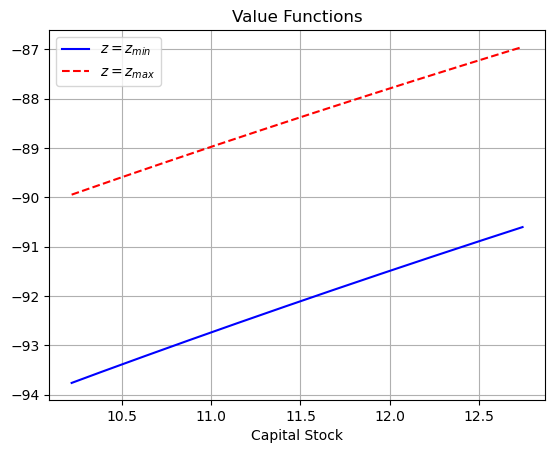

In [15]:
# Plot value function
fig1, ax1 = plt.subplots()
ax1.plot(k, V1[:,0], 'b', label = '$z=z_{min}$')
ax1.plot(k, V1[:,-1], 'r--', label = '$z=z_{max}$')

ax1.set(xlabel='Capital Stock', title='Value Functions')
ax1.grid()
ax1.legend()

fig1.savefig("Hansen_DDP_value.jpg", dpi=800)
plt.show()

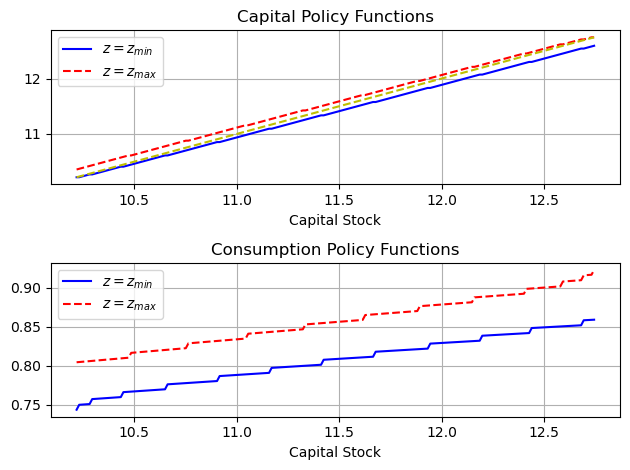

In [16]:
# Plot capital and consumption policy functions
fig2, axs2 = plt.subplots(2, 1)

axs2[0].plot(k, polk[:,0], 'b', label = '$z=z_{min}$')
axs2[0].plot(k, polk[:,-1], 'r--', label = '$z=z_{max}$')
axs2[0].plot(k, k, 'y--')
axs2[0].set(xlabel='Capital Stock', title='Capital Policy Functions')
axs2[0].grid()
axs2[0].legend()



axs2[1].plot(k, polc[:,0], 'b', label = '$z=z_{min}$')
axs2[1].plot(k, polc[:,-1], 'r--', label = '$z=z_{max}$')
axs2[1].set(xlabel='Capital Stock', title='Consumption Policy Functions')
axs2[1].grid()
axs2[1].legend()


plt.tight_layout()
plt.savefig('Hansen_DDP_policy.jpg', dpi=800)
plt.show()
plt.close(fig2)

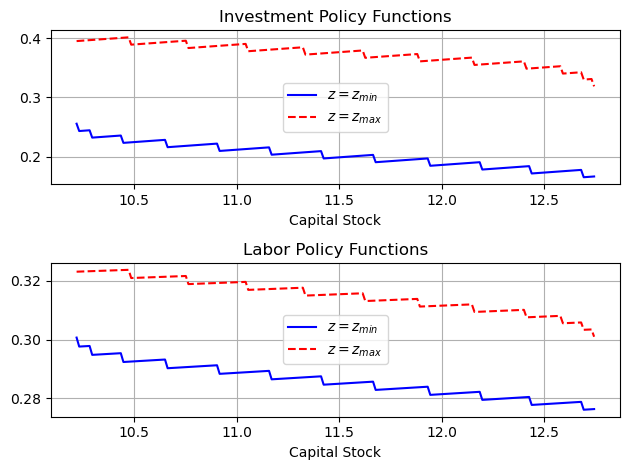

In [17]:
# Plot investment and labor policy functions
fig3, axs3 = plt.subplots(2, 1)

axs3[0].plot(k, poli[:,0], 'b', label = '$z=z_{min}$')
axs3[0].plot(k, poli[:,-1], 'r--', label = '$z=z_{max}$')
axs3[0].set(xlabel='Capital Stock', title='Investment Policy Functions')
axs3[0].grid()
axs3[0].legend()



axs3[1].plot(k, lpol[:,0], 'b', label = '$z=z_{min}$')
axs3[1].plot(k, lpol[:,-1], 'r--', label = '$z=z_{max}$')
axs3[1].set(xlabel='Capital Stock', title='Labor Policy Functions')
axs3[1].grid()
axs3[1].legend()


plt.tight_layout()
plt.savefig('Hansen_DDP_policy.jpg', dpi=800)
plt.show()
plt.close(fig3)

In [18]:
# Monte-Carlo Simulation

if lk < 10:
    siyes = 0


if siyes == 1:
    np.random.seed(0)
    
    T = 115  # simulation time period
    n = 100  # # of simulations
    
    tind = np.zeros((n,T+1),dtype=np.int8)
    kopt = np.zeros((n,T+1))
    zt = np.zeros((n,T+1))
    lopt = np.zeros((n,T))
    output = np.zeros((n,T))
    invest = np.zeros((n,T))
    cons = np.zeros((n,T))
    ss_mat = np.zeros((n,6))
    cc_mat = np.zeros((n,6))
    
    for i in np.arange(0,n):
        tind[i,0] = 4
        zt[i,0] = z[tind[i,0]]
        indk = round(lk/2)-1
        kopt[i,0] = polk[indk,0]
    
        for t in np.arange(0,T):
            indk = optk[indk,tind[i,t]]
            kopt[i,t+1] = polk[indk,tind[i,t]]
            lopt[i,t] = lpol[indk,tind[i,t]]
            output[i,t] = zt[i,t]*(kopt[i,t]**alf*lopt[i,t]**(1-alf))
            invest[i,t] = kopt[i,t+1]-(1-delta)*kopt[i,t]
            cons[i,t] = polc[indk,tind[i,t]]
            
            shock = np.random.random()
            j = 0
            while Tran[tind[i,t],0:j+1].sum() < shock:
                j = j + 1

            tind[i,t+1] = j
            zt[i,t+1] = z[j]
            
            
        logy = np.log(output[i,0:T])[np.newaxis,:]
        logc = np.log(cons[i,0:T])[np.newaxis,:]
        loginv = np.log(invest[i,0:T])[np.newaxis,:]
        logk = np.log(kopt[i,0:T])[np.newaxis,:]
        logl = np.log(lopt[i,0:T])[np.newaxis,:]
        logz = np.log(zt[i,0:T])[np.newaxis,:]
        
        
        dhp, dtr = hp1(np.concatenate((logy.T, logc.T, loginv.T, logk.T, logl.T, logz.T),axis=1), 1600)
        ss_mat[i,:] = np.std(dhp,axis=0)*100
        Corr = np.corrcoef(dhp,rowvar=False)
        #print(ss_mat[i,:].shape)
        #print(Corr.shape)
        cc_mat[i,:] = Corr[:,0]
            

    stdv = np.mean(ss_mat,axis=0)
    stdv_stdv = np.std(ss_mat,axis=0)
    corr = np.mean(cc_mat,axis=0)
    corr_stdv = np.std(cc_mat,axis=0)
    
    
    print('HANSEN: std(x)/std(y) corr(x,y) for y, c, i, k, h, prod')
    print(np.concatenate((np.array([[1.36, 0.42, 4.24, 0.36, 0.7, 0.68]]).T/1.36, \
                          np.array([[1, 0.89, 0.99, 0.06, 0.98, 0.98]]).T),axis=1))
    print('std(x) std(x)/std(y)  stdv_stdv corr(x,y) corr_stdv for y, c, i, k, h, prod:')
    print(np.concatenate((stdv[:,np.newaxis], (stdv/stdv[0])[:,np.newaxis], stdv_stdv[:,np.newaxis],\
                          corr[:,np.newaxis], corr_stdv[:,np.newaxis]),axis=1))

HANSEN: std(x)/std(y) corr(x,y) for y, c, i, k, h, prod
[[1.     1.    ]
 [0.3088 0.89  ]
 [3.1176 0.99  ]
 [0.2647 0.06  ]
 [0.5147 0.98  ]
 [0.5    0.98  ]]
std(x) std(x)/std(y)  stdv_stdv corr(x,y) corr_stdv for y, c, i, k, h, prod:
[[1.4072 1.     0.2344 1.     0.    ]
 [0.5711 0.4059 0.0958 0.8424 0.0424]
 [6.9382 4.9306 0.9062 0.7647 0.0319]
 [0.4081 0.29   0.085  0.2495 0.0676]
 [0.689  0.4896 0.1084 0.9472 0.0163]
 [0.9593 0.6817 0.1595 0.9914 0.0032]]


In [19]:
#!jupyter nbconvert --to script Hansen_DDP.ipynb